In [17]:
import pandas as pd
import numpy as np
from transformers import DebertaTokenizer, DebertaModel
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    multilabel_confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import argparse
import os
import json
from datetime import datetime

In [18]:
# Add GPU count check at the top level
def get_available_gpus():
    """Get the number of available GPUs and their IDs"""
    if not torch.cuda.is_available():
        return 0, []
    
    n_gpus = torch.cuda.device_count()
    gpu_ids = list(range(n_gpus))
    return n_gpus, gpu_ids

In [19]:
class IssueDataset(Dataset):
    """
    Dataset for processing text data and multi-label classification.

    Args:
        texts (pd.Series): Series of input texts.
        labels (list or pd.Series): Corresponding labels (one-hot encoded for multi-label).
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer for converting text to tokens.
        max_length (int): Maximum length of tokenized sequences (default is 512).
    """
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts.reset_index(drop=True)
        # Reset index for labels if it's a pandas Series.
        if isinstance(labels, pd.Series):
            self.labels = labels.reset_index(drop=True)
        else:
            self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        encodings = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )
        
        # For multi-label classification, ensure we're passing the full label array
        # and not just a single value
        label = self.labels[idx]
        
        # Make sure we're getting a proper multi-dimensional label array
        # and not flattening it incorrectly
        if isinstance(label, (list, np.ndarray)):
            # Convert directly to tensor without modifying shape
            label = torch.tensor(label, dtype=torch.float)
        else:
            # If it's not already an array-like structure, this is likely a mistake
            # as we expect multi-label one-hot encoded data
            raise ValueError(f"Expected multi-dimensional label array but got {type(label)}")
        
        return {
            'input_ids': encodings['input_ids'].flatten(),
            'attention_mask': encodings['attention_mask'].flatten(),
            'labels': label
        }
  

In [20]:
class DeBERTaClassifier(nn.Module):
    """
    A classifier model based on DeBERTa for multi-label classification.
    
    This model uses a pre-trained DeBERTa model as the encoder and adds a 
    classification head on top with sigmoid activation for multi-label output.
    
    Args:
        num_labels (int): Number of classes in the multi-label classification task.
    """
    def __init__(self, num_labels):
        super().__init__()
        self.deberta = DebertaModel.from_pretrained('microsoft/deberta-base')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, num_labels)
        # Freeze all parameters in DeBERTa
        for param in self.deberta.parameters():
            param.requires_grad = False
        # Unfreeze encoder parameters for fine-tuning
        # Note: DeBERTa has a different architecture than BERT/RoBERTa
        # We'll unfreeze the last 3 encoder layers
        for layer in self.deberta.encoder.layer[-3:]:
            for param in layer.parameters():
                param.requires_grad = True

    def forward(self, input_ids, attention_mask):
        outputs = self.deberta(input_ids=input_ids, attention_mask=attention_mask)
        # Unlike BERT, DeBERTa doesn't have a pooler, so we need to take the last hidden state
        # and either use the [CLS] token (first token) or do mean pooling
        # Here we'll use the [CLS] token (first token) representation
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        # Return raw logits for BCEWithLogitsLoss (sigmoid will be applied in the loss function)
        return self.classifier(cls_output)
  

In [21]:
class EarlyStopping:
    """
    Early stopping to stop training when the validation loss does not improve sufficiently.
    
    For multi-label classification, we consider a loss improvement when 
    the validation loss decreases by at least min_delta.
    
    Args:
        patience (int): Number of epochs to wait for an improvement before stopping.
        min_delta (float): Minimum decrease in the monitored loss to qualify as an improvement.
    """
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def reset(self):
        """Reset the early stopping state."""
        self.counter = 0
        self.best_loss = None
        self.early_stop = False


In [22]:
def train_epoch(model, loader, criterion, optimizer, device, threshold=0.5, early_stopping=None):
    """
    Train the model for one epoch, computing loss and metrics for multi-label classification.

    Args:
        model (nn.Module): The multi-label classification model.
        loader (DataLoader): Training DataLoader.
        criterion: Loss function (BCEWithLogitsLoss).
        optimizer: Optimization algorithm.
        device: Device to perform training (CPU or GPU).
        threshold (float): Threshold for binary predictions (default is 0.5).
        early_stopping (EarlyStopping, optional): Instance to monitor improvement in loss.

    Returns:
        tuple: Average loss, Hamming accuracy, and a flag indicating if early stopping was triggered.
    """
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for batch in tqdm(loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        # Apply sigmoid and threshold for predictions
        predictions = torch.sigmoid(outputs) >= threshold
        all_preds.append(predictions.cpu().detach().numpy())
        all_labels.append(labels.cpu().detach().numpy())
    
    # Calculate metrics for multi-label classification
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    # Use subset accuracy (exact match) for a strict measure
    exact_match = (all_preds == all_labels).all(axis=1).mean()
    
    avg_loss = total_loss / len(loader)
    
    if early_stopping:
        early_stopping(avg_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            return avg_loss, exact_match, True
            
    return avg_loss, exact_match, False
 

In [23]:
def validate(model, loader, criterion, device, threshold=0.5):
    """
    Evaluate the model on provided validation data for multi-label classification.

    Args:
        model (nn.Module): The multi-label classification model.
        loader (DataLoader): Validation DataLoader.
        criterion: Loss function (BCEWithLogitsLoss).
        device: Device to perform evaluation.
        threshold (float): Threshold for binary predictions (default is 0.5).

    Returns:
        tuple: Average loss, various accuracy metrics, precision, recall, and F1 score.
    """
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            # Apply sigmoid and threshold for predictions
            predictions = (torch.sigmoid(outputs) >= threshold).float()
            all_preds.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    # Calculate different multi-label metrics
    
    # 1. Exact Match / Subset Accuracy (all labels must be correct)
    exact_match = (all_preds == all_labels).all(axis=1).mean()
    
    # 2. Partial Match Accuracy (only count correctly predicted 1s, ignore 0s)
    # Calculate true positives per sample
    true_positives = np.logical_and(all_preds == 1, all_labels == 1).sum(axis=1)
    # Calculate total actual positives per sample
    total_positives = (all_labels == 1).sum(axis=1)
    # Handle division by zero - samples with no positive labels get a score of 0
    partial_match = np.zeros_like(true_positives, dtype=float)
    # Only calculate ratio for samples with at least one positive label
    mask = total_positives > 0
    partial_match[mask] = true_positives[mask] / total_positives[mask]
    partial_match_accuracy = partial_match.mean()
    
    # 3. Jaccard Similarity (intersection over union)
    def jaccard_score(y_true, y_pred):
        intersection = np.logical_and(y_true, y_pred).sum(axis=1)
        union = np.logical_or(y_true, y_pred).sum(axis=1)
        # Create a float array for output to avoid type casting error
        result = np.zeros_like(intersection, dtype=float)
        # Avoid division by zero
        np.divide(intersection, union, out=result, where=union!=0)
        return np.mean(result)
    
    jaccard_sim = jaccard_score(all_labels.astype(bool), all_preds.astype(bool))
    
    # Add Hamming metric - this is the same as partial_match_accuracy
    hamming_sim = partial_match_accuracy
    
    # Sample-based metrics - Each sample contributes equally regardless of number of labels
    precision = precision_score(all_labels, all_preds, average='samples', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='samples', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='samples', zero_division=0)
    
    return (total_loss / len(loader), 
            {"exact_match": exact_match, 
             "partial_match": partial_match_accuracy,
             "hamming": hamming_sim,
             "jaccard": jaccard_sim}, 
            precision, recall, f1)


In [24]:
def plot_multilabel_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot confusion matrices for each label in a multi-label classification problem.
    
    Args:
        y_true (numpy.ndarray): True binary labels.
        y_pred (numpy.ndarray): Predicted binary labels.
        class_names (list): Names of the classes/labels.
    """
    confusion_matrices = multilabel_confusion_matrix(y_true, y_pred)
    
    num_classes = len(class_names)
    fig, axes = plt.subplots(nrows=(num_classes + 3) // 4, ncols=min(4, num_classes), 
                             figsize=(20, 5 * ((num_classes + 3) // 4)))
    if num_classes == 1:
        axes = np.array([axes])  # Make it indexable for single class
    axes = axes.flatten()
    
    for i, matrix in enumerate(confusion_matrices):
        if i < num_classes:  # Ensure we don't exceed the number of classes
            ax = axes[i]
            sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
            ax.set_title(f'Label: {class_names[i]}')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('True')
            ax.set_xticklabels(['Negative', 'Positive'])
            ax.set_yticklabels(['Negative', 'Positive'])
    
    # Hide any unused subplots
    for i in range(num_classes, len(axes)):
        fig.delaxes(axes[i])
        
    plt.tight_layout()
    return fig


In [25]:
def prepare_data(df, text_column='all_text', min_label_freq=0, max_label_len=100, min_label_comb_freq=0):
    """
    Filter out infrequent labels and samples with too many labels.
    
    Args:
        df (pd.DataFrame): DataFrame with text column and 'labels'
        text_column (str): Name of the column containing the text data to use
        min_label_freq (int): Minimum frequency for a label to be considered frequent.
        max_label_len (int): Maximum number of labels per sample.
        min_label_comb_freq (int): Minimum frequency for a label combination to be kept.

    Returns:
        tuple: Filtered texts and labels.
    """
    # Only keep text column and 'labels' columns
    if text_column in df.columns:
        df = df[[text_column, 'labels']]
        # Filter out rows with 'nan' text
        df = df[~df[text_column].apply(lambda x: x.startswith('nan') if isinstance(x, str) else False)]
    else:
        raise ValueError(f"Text column '{text_column}' not found in the DataFrame. Available columns: {df.columns.tolist()}")
    
    # Drop rows with missing labels
    df = df.dropna()
    
    # Extract issue texts and labels
    texts = df[text_column]
    labels = df['labels'].apply(lambda x: x if isinstance(x, list) else [])  # Ensure labels are lists

    # Get labels count distribution
    label_distribution = Counter([label for labels in labels for label in labels])

    # Labels to keep based on frequency
    frequent_labels = [label for label, count in label_distribution.items() if count >= min_label_freq]
    print(f"Number of labels with at least {min_label_freq} occurrences: {len(frequent_labels)}")
    print(f"Removed {len(label_distribution) - len(frequent_labels)} infrequent labels")

    # Filter out infrequent labels
    filtered_labels = labels.apply(lambda x: [label for label in x if label in frequent_labels])
    print(f"Number of samples after filtering: {len(filtered_labels)}")

    # Get label combinations distribution
    label_combinations = Counter([tuple(sorted(labels)) for labels in filtered_labels])
    frequent_combinations = {labels: count for labels, count in label_combinations.items() if count >= min_label_comb_freq}
    print(f"Number of label combinations with at least {min_label_comb_freq} occurrences: {len(frequent_combinations)}")
    print(f"Removed {len(label_combinations) - len(frequent_combinations)} infrequent label combinations")
    
    # Create mask for samples with frequent label combinations (if min_label_comb_freq > 0)
    if min_label_comb_freq > 0:
        comb_mask = filtered_labels.apply(lambda x: tuple(sorted(x)) in frequent_combinations)
        print(f"Number of samples with frequent label combinations: {comb_mask.sum()}")
    else:
        comb_mask = pd.Series([True] * len(filtered_labels))
    
    # Filter by label length
    label_length = filtered_labels.apply(len)
    length_mask = (label_length > 0) & (label_length <= max_label_len)
    
    # Combine both masks
    final_mask = comb_mask & length_mask
    
    # Now get the final filtered texts and labels
    texts = texts[final_mask].reset_index(drop=True)
    filtered_labels = filtered_labels[final_mask].reset_index(drop=True)
    
    print(f"Final number of samples after all filtering: {len(filtered_labels)}")
    
    return texts, filtered_labels


In [26]:
class PCAEmbeddingDataset(Dataset):
    """
    Dataset that uses PCA to reduce the dimensionality of token embeddings.
    
    Args:
        texts (pd.Series): Series of input texts.
        labels (list or pd.Series): Corresponding labels (one-hot encoded for multi-label).
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer for converting text to tokens.
        model (transformers.PreTrainedModel): Model to extract embeddings from tokenized text.
        pca (sklearn.decomposition.PCA): Fitted PCA object for dimensionality reduction.
        max_length (int): Maximum length of tokenized sequences (default is 512).
    """
    def __init__(self, texts, labels, tokenizer, model, pca, max_length=512, device='cpu'):
        self.texts = texts.reset_index(drop=True)
        # Reset index for labels if it's a pandas Series
        if isinstance(labels, pd.Series):
            self.labels = labels.reset_index(drop=True)
        else:
            self.labels = labels
        self.tokenizer = tokenizer
        self.model = model
        self.pca = pca
        self.max_length = max_length
        self.device = device
        self.embeddings = self._precompute_embeddings()
    
    def _precompute_embeddings(self):
        """Precompute embeddings with PCA reduction for all texts"""
        all_embeddings = []
        self.model.eval()  # Set model to evaluation mode
        
        with torch.no_grad():
            for i in tqdm(range(len(self.texts)), desc="Computing PCA embeddings"):
                text = str(self.texts.iloc[i])
                encodings = self.tokenizer(
                    text,
                    truncation=True,
                    max_length=self.max_length,
                    padding='max_length',
                    return_tensors='pt'
                )
                
                # Move to device
                input_ids = encodings['input_ids'].to(self.device)
                attention_mask = encodings['attention_mask'].to(self.device)
                
                # Get the embeddings
                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # CLS token embedding
                
                # Apply PCA reduction
                reduced_embedding = self.pca.transform(embedding)
                all_embeddings.append(reduced_embedding.flatten())
                
        return all_embeddings
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        # Directly return the precomputed PCA-reduced embedding
        embedding = torch.tensor(self.embeddings[idx], dtype=torch.float)
        
        # For multi-label classification
        label = self.labels[idx]
        
        if isinstance(label, (list, np.ndarray)):
            label = torch.tensor(label, dtype=torch.float)
        else:
            raise ValueError(f"Expected multi-dimensional label array but got {type(label)}")
        
        return {
            'embedding': embedding,
            'labels': label
        }


In [27]:
class DeBERTaPCAClassifier(nn.Module):
    """
    A classifier model that takes PCA-reduced DeBERTa embeddings and applies
    a classification head for multi-label classification.
    
    Args:
        input_dim (int): Dimension of the PCA-reduced embeddings.
        num_labels (int): Number of classes in the multi-label classification task.
    """
    def __init__(self, input_dim, num_labels):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_labels)
        )

    def forward(self, embeddings):
        return self.classifier(embeddings)


In [28]:
def fit_pca_on_embeddings(texts, tokenizer, model, n_components=128, max_length=512, device='cpu'):
    """
    Fit PCA on DeBERTa embeddings from a sample of texts.
    
    Args:
        texts (pd.Series): Series of input texts to extract embeddings from.
        tokenizer: The tokenizer to use for encoding texts.
        model: The pre-trained model to extract embeddings from.
        n_components (int): Number of PCA components to keep.
        max_length (int): Maximum length of tokenized sequences.
        device (str): Device to perform computations on.
        
    Returns:
        tuple: Fitted PCA object and explained variance plot.
    """
    print(f"Fitting PCA with {n_components} components on embeddings...")
    model.eval()  # Set model to evaluation mode
    
    # Sample texts if there are too many (for memory efficiency)
    sample_size = min(len(texts), 5000)
    if len(texts) > sample_size:
        sample_indices = np.random.choice(len(texts), sample_size, replace=False)
        sample_texts = texts.iloc[sample_indices]
    else:
        sample_texts = texts
    
    # Extract embeddings
    embeddings = []
    with torch.no_grad():
        for i in tqdm(range(len(sample_texts)), desc="Extracting embeddings for PCA"):
            text = str(sample_texts.iloc[i])
            encodings = tokenizer(
                text,
                truncation=True,
                max_length=max_length,
                padding='max_length',
                return_tensors='pt'
            )
            
            # Move to device
            input_ids = encodings['input_ids'].to(device)
            attention_mask = encodings['attention_mask'].to(device)
            
            # Get the embeddings (use CLS token)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # CLS token embedding
            embeddings.append(embedding)
    
    # Stack all embeddings
    embeddings = np.vstack(embeddings)
    
    # Fit PCA
    pca = PCA(n_components=n_components)
    pca.fit(embeddings)
    
    # Calculate explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    
    # Plot explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Explained Variance by PCA Components')
    plt.grid(True)
    plt.tight_layout()
    
    # Find components for different thresholds
    thresholds = [0.9, 0.95, 0.99, 0.999]
    components_needed = {}
    
    for threshold in thresholds:
        components = np.argmax(cumulative_variance >= threshold) + 1
        components_needed[threshold] = components
        print(f"Components needed for {threshold*100}% variance: {components}")
        plt.axhline(y=threshold, color='r', linestyle='--', alpha=0.3)
        plt.axvline(x=components, color='r', linestyle='--', alpha=0.3)
    
    return pca, plt.gcf(), components_needed


In [29]:
def train_epoch_pca(model, loader, criterion, optimizer, device, threshold=0.5, early_stopping=None):
    """
    Train the model for one epoch using PCA-reduced embeddings.
    """
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for batch in tqdm(loader, desc="Training"):
        embeddings = batch['embedding'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        outputs = model(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        # Apply sigmoid and threshold for predictions
        predictions = torch.sigmoid(outputs) >= threshold
        all_preds.append(predictions.cpu().detach().numpy())
        all_labels.append(labels.cpu().detach().numpy())
    
    # Calculate metrics
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    exact_match = (all_preds == all_labels).all(axis=1).mean()
    
    avg_loss = total_loss / len(loader)
    
    if early_stopping:
        early_stopping(avg_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            return avg_loss, exact_match, True
            
    return avg_loss, exact_match, False


In [30]:
def validate_pca(model, loader, criterion, device, threshold=0.5):
    """
    Evaluate the model on provided validation data using PCA-reduced embeddings.
    """
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in loader:
            embeddings = batch['embedding'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            # Apply sigmoid and threshold for predictions
            predictions = (torch.sigmoid(outputs) >= threshold).float()
            all_preds.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    # Calculate metrics
    exact_match = (all_preds == all_labels).all(axis=1).mean()
    
    # Partial match (only count correctly predicted 1s)
    true_positives = np.logical_and(all_preds == 1, all_labels == 1).sum(axis=1)
    total_positives = (all_labels == 1).sum(axis=1)
    partial_match = np.zeros_like(true_positives, dtype=float)
    mask = total_positives > 0
    partial_match[mask] = true_positives[mask] / total_positives[mask]
    partial_match_accuracy = partial_match.mean()
    
    # Jaccard Similarity
    def jaccard_score(y_true, y_pred):
        intersection = np.logical_and(y_true, y_pred).sum(axis=1)
        union = np.logical_or(y_true, y_pred).sum(axis=1)
        result = np.zeros_like(intersection, dtype=float)
        np.divide(intersection, union, out=result, where=union!=0)
        return np.mean(result)
    
    jaccard_sim = jaccard_score(all_labels.astype(bool), all_preds.astype(bool))
    hamming_sim = partial_match_accuracy
    
    # Sample-based metrics
    precision = precision_score(all_labels, all_preds, average='samples', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='samples', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='samples', zero_division=0)
    
    return (total_loss / len(loader), 
            {"exact_match": exact_match, 
             "partial_match": partial_match_accuracy,
             "hamming": hamming_sim,
             "jaccard": jaccard_sim}, 
            precision, recall, f1)


In [31]:
def main(args):
    """
    Main function to run the multi-label classification pipeline with DeBERTa and PCA.
    """
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Check for GPU availability
    n_gpus, gpu_ids = get_available_gpus()
    if n_gpus >= 2:
        print(f"Using {n_gpus} GPUs: {gpu_ids}")
        device = torch.device("cuda")
        use_multi_gpu = True
    elif n_gpus == 1:
        print("Using 1 GPU")
        device = torch.device("cuda")
        use_multi_gpu = False
    else:
        print("No GPUs available, using CPU")
        device = torch.device("cpu")
        use_multi_gpu = False
    
    # Make results directory if it doesn't exist
    results_dir = args.results_dir
    os.makedirs(results_dir, exist_ok=True)
    
    # Create a timestamped directory for this run
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_dir = os.path.join(results_dir, f"run_{timestamp}_{args.text_column}_pca{args.pca_components}")
    os.makedirs(run_dir, exist_ok=True)
    
    # Load data
    print(f"Loading data from {args.data_path}...")
    df = pd.read_json(args.data_path)
    
    # Check if the text column exists
    if args.text_column not in df.columns:
        available_columns = [col for col in df.columns if col.startswith('all_text')]
        print(f"Text column '{args.text_column}' not found. Available text columns: {available_columns}")
        if len(available_columns) == 0:
            raise ValueError("No text columns found in the data")
        args.text_column = available_columns[0]
        print(f"Using '{args.text_column}' instead")
    
    # Use prepare_data function to filter and prepare data
    texts, filtered_labels = prepare_data(
        df, 
        text_column=args.text_column,
        min_label_freq=args.min_label_freq, 
        max_label_len=args.max_label_len, 
        min_label_comb_freq=args.min_label_comb_freq
    )
    
    # Count the number of labels distribution
    label_distribution = Counter([label for labels in filtered_labels for label in labels])
    print('\n Label Distribution : ')
    for i, (label, count) in enumerate(sorted(label_distribution.items(), key=lambda x: x[1], reverse=True)):
        print(f'{i}. {label}: {count}')
    
    # Count the label length distribution
    label_length_distribution = Counter([len(labels) for labels in filtered_labels])
    print('\n Label count per row distribution:')
    for label in sorted(label_length_distribution.keys()):
        print(f'Label: {label}, count: {label_length_distribution[label]}')

    # Encode multi-labels using MultiLabelBinarizer
    print("Encoding labels...")
    mlb = MultiLabelBinarizer()
    labels_encoded = mlb.fit_transform(filtered_labels)
    
    # Save label encoder for future use
    with open(os.path.join(run_dir, 'label_encoder.json'), 'w') as f:
        json.dump({
            'classes': mlb.classes_.tolist()
        }, f)
    
    # Split data into training and validation sets (80% training, 20% validation)
    split_idx = int(len(texts) * 0.8)
    train_texts, val_texts = texts[:split_idx], texts[split_idx:]
    train_labels, val_labels = labels_encoded[:split_idx], labels_encoded[split_idx:]
    
    print(f"Training samples: {len(train_texts)}, Validation samples: {len(val_texts)}")
    
    # Initialize tokenizer and model for embedding extraction
    print("Loading tokenizer and base model...")
    tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')
    base_model = DebertaModel.from_pretrained('microsoft/deberta-base')
    base_model.to(device)
    
    # Fit PCA on embeddings
    pca, pca_plot, components_needed = fit_pca_on_embeddings(
        train_texts, 
        tokenizer, 
        base_model, 
        n_components=args.pca_components,
        device=device
    )
    
    # Save the PCA plot
    pca_plot.savefig(os.path.join(run_dir, 'pca_explained_variance.png'))
    
    # Save PCA component information
    with open(os.path.join(run_dir, 'pca_components.json'), 'w') as f:
        # Convert NumPy int64 to Python int
        components_needed_native = {k: int(v) for k, v in components_needed.items()}
        json.dump({
            'n_components': args.pca_components,
            'explained_variance_ratio': pca.explained_variance_ratio_.tolist(),
            'cumulative_variance': np.cumsum(pca.explained_variance_ratio_).tolist(),
            'components_needed': components_needed_native
        }, f)
    
    # Create datasets with PCA reduction
    print("Creating PCA-reduced datasets...")
    train_dataset = PCAEmbeddingDataset(
        train_texts, train_labels, tokenizer, base_model, pca, device=device
    )
    val_dataset = PCAEmbeddingDataset(
        val_texts, val_labels, tokenizer, base_model, pca, device=device
    )
    
    # Create dataloaders
    batch_size = args.batch_size
    if use_multi_gpu:
        batch_size = batch_size * n_gpus
        print(f"Using larger batch size of {batch_size} for {n_gpus} GPUs")
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Initialize the PCA classifier model
    print("Initializing PCA classifier model...")
    model = DeBERTaPCAClassifier(input_dim=args.pca_components, num_labels=len(mlb.classes_)).to(device)
    
    # Implement class weights for loss function to handle imbalance
    label_counts = labels_encoded.sum(axis=0)
    pos_weights = None
    if args.use_class_weights and label_counts.min() < label_counts.max() / 5:
        print("Computing class weights for imbalanced labels...")
        pos_weights = torch.FloatTensor(
            (labels_encoded.shape[0] - label_counts) / label_counts
        ).clamp(0.5, 10).to(device)
    
    # Use weighted loss if we have weights
    if pos_weights is not None:
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
        print("Using weighted BCE loss")
    else:
        criterion = nn.BCEWithLogitsLoss()
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.learning_rate)
    
    # Initialize early stopping
    early_stopping = EarlyStopping(patience=args.patience, min_delta=0.01)
    
    # Training loop
    num_epochs = args.epochs
    print(f"Starting training for {num_epochs} epochs...")
    
    train_losses = []
    val_losses = []
    best_f1 = 0.0
    best_model_saved = False
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Train for one epoch using PCA embeddings
        train_loss, train_acc, stop_early = train_epoch_pca(
            model, train_loader, criterion, optimizer, device, early_stopping=early_stopping
        )
        
        # Validate using PCA embeddings
        val_loss, accuracy_metrics, val_precision, val_recall, val_f1 = validate_pca(
            model, val_loader, criterion, device
        )
        
        # Save metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy (Exact Match): {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}")
        print(f"Val Accuracy (Exact Match): {accuracy_metrics['exact_match']:.4f}")
        print(f"Val Accuracy (Partial Match): {accuracy_metrics['partial_match']:.4f}")
        print(f"Val Accuracy (Jaccard): {accuracy_metrics['jaccard']:.4f}")
        print(f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")
        
        # Save best model based on F1 score
        model_path = os.path.join(run_dir, f'best_model_{args.text_column}_pca{args.pca_components}.pt')
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), model_path)
            print(f"Saved new best model to {model_path}")
            best_model_saved = True
        
        # Always save a model for the first epoch if no model has been saved yet
        if epoch == 0 and not best_model_saved:
            torch.save(model.state_dict(), model_path)
            print(f"Saved initial model to {model_path} as baseline")
            best_model_saved = True
            
        # Check for early stopping
        if stop_early:
            print("Early stopping triggered. Terminating training.")
            break
    
    # Save training history
    history = {
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    with open(os.path.join(run_dir, 'training_history.json'), 'w') as f:
        json.dump(history, f)
    
    # Load best model for final evaluation
    print("\nLoading best model for final evaluation...")
    best_model_path = os.path.join(run_dir, f'best_model_{args.text_column}_pca{args.pca_components}.pt')
    model.load_state_dict(torch.load(best_model_path))
    
    # Evaluate the model with default threshold
    print("\nFinal evaluation with default threshold (0.5):")
    final_loss, final_acc_metrics, final_precision, final_recall, final_f1 = validate_pca(
        model, val_loader, criterion, device
    )
    
    print(f"Exact Match Accuracy: {final_acc_metrics['exact_match']:.4f}")
    print(f"Partial Match Accuracy: {final_acc_metrics['partial_match']:.4f}")
    print(f"Jaccard Similarity: {final_acc_metrics['jaccard']:.4f}")
    print(f"Precision: {final_precision:.4f}")
    print(f"Recall: {final_recall:.4f}")
    print(f"F1 Score: {final_f1:.4f}")
    
    # Save results
    results = {
        'text_column': args.text_column,
        'pca_components': args.pca_components,
        'metrics': {
            'exact_match': float(final_acc_metrics['exact_match']),
            'partial_match': float(final_acc_metrics['partial_match']),
            'jaccard': float(final_acc_metrics['jaccard']),
            'precision': float(final_precision),
            'recall': float(final_recall), 
            'f1': float(final_f1),
        }
    }
    with open(os.path.join(run_dir, 'results.json'), 'w') as f:
        json.dump(results, f, indent=4)
    
    # Collect predictions with default threshold for confusion matrices
    model.eval()
    all_preds = []
    all_val_labels = []
    
    with torch.no_grad():
        for batch in val_loader:
            embeddings = batch['embedding'].to(device)
            outputs = model(embeddings)
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            
            all_preds.append(preds.cpu().numpy())
            all_val_labels.append(batch['labels'].numpy())
    
    all_preds = np.vstack(all_preds)
    all_val_labels = np.vstack(all_val_labels)
    
    # Plot and save confusion matrices (up to 20 labels to avoid too many plots)
    num_labels_to_plot = min(20, len(mlb.classes_))
    fig = plot_multilabel_confusion_matrix(
        all_val_labels[:, :num_labels_to_plot], 
        all_preds[:, :num_labels_to_plot], 
        mlb.classes_[:num_labels_to_plot]
    )
    plt.savefig(os.path.join(run_dir, 'confusion_matrices.png'))
    
    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training History - {args.text_column} with PCA ({args.pca_components} components)')
    plt.legend()
    plt.savefig(os.path.join(run_dir, 'training_history.png'))
    
    print(f"\nTraining completed! Results saved to {run_dir}")
    
    return {
        'metrics': results['metrics'],
        'model': model,
        'label_encoder': mlb,
        'results_dir': run_dir
    }


Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json...
Number of labels with at least 5 occurrences: 20
Removed 19 infrequent labels
Number of samples after filtering: 1258
Number of label combinations with at least 2 occurrences: 52
Removed 57 infrequent label combinations
Number of samples with frequent label combinations: 1201
Final number of samples after all filtering: 1177

 Label Distribution : 
0. area/kubelet: 358
1. area/test: 303
2. area/apiserver: 209
3. area/cloudprovider: 183
4. area/kubectl: 135
5. area/provider/azure: 66
6. area/dependency: 64
7. area/code-generation: 48
8. area/ipvs: 44
9. area/kubeadm: 39
10. area/kube-proxy: 27
11. area/provider/gcp: 22
12. area/e2e-test-framework: 17
13. area/conformance: 16
14. area/custom-resources: 15
15. area/release-eng: 14
16. area/security: 10
17. area/etcd: 5
18. area/provider/openstack: 5
19. area/provider/vmware: 2

 Label count pe

Extracting embeddings for PCA: 100%|██████████| 941/941 [01:11<00:00, 13.15it/s]


Components needed for 90.0% variance: 39
Components needed for 95.0% variance: 78
Components needed for 99.0% variance: 1
Components needed for 99.9% variance: 1
Creating PCA-reduced datasets...


Computing PCA embeddings: 100%|██████████| 236/236 [00:17<00:00, 13.55it/s]


Using larger batch size of 32 for 2 GPUs
Initializing PCA classifier model...
Starting training for 20 epochs...

Epoch 1/20


Training: 100%|██████████| 30/30 [00:00<00:00, 86.65it/s]


Train Loss: 0.6942, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6927
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.5827
Val Accuracy (Jaccard): 0.0658
Val Precision: 0.0670, Val Recall: 0.5827, Val F1: 0.1179
Saved new best model to ./results/run_20250325_172949_all_text_pca128/best_model_all_text_pca128.pt

Epoch 2/20


Training: 100%|██████████| 30/30 [00:00<00:00, 466.98it/s]


Train Loss: 0.6905, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6891
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.4629
Val Accuracy (Jaccard): 0.0646
Val Precision: 0.0667, Val Recall: 0.4629, Val F1: 0.1139

Epoch 3/20


Training: 100%|██████████| 30/30 [00:00<00:00, 434.65it/s]


Train Loss: 0.6869, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6854
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.1585
Val Accuracy (Jaccard): 0.0340
Val Precision: 0.0378, Val Recall: 0.1585, Val F1: 0.0577

Epoch 4/20


Training: 100%|██████████| 30/30 [00:00<00:00, 486.95it/s]


Train Loss: 0.6833, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6817
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0520
Val Accuracy (Jaccard): 0.0174
Val Precision: 0.0222, Val Recall: 0.0520, Val F1: 0.0281

Epoch 5/20


Training: 100%|██████████| 30/30 [00:00<00:00, 494.57it/s]


Train Loss: 0.6796, Train Accuracy (Exact Match): 0.0021
Val Loss: 0.6780
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0097
Val Accuracy (Jaccard): 0.0070
Val Precision: 0.0155, Val Recall: 0.0097, Val F1: 0.0112

Epoch 6/20


Training: 100%|██████████| 30/30 [00:00<00:00, 486.96it/s]


Train Loss: 0.6759, Train Accuracy (Exact Match): 0.0096
Val Loss: 0.6742
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0047
Val Accuracy (Jaccard): 0.0047
Val Precision: 0.0169, Val Recall: 0.0047, Val F1: 0.0073

Epoch 7/20


Training: 100%|██████████| 30/30 [00:00<00:00, 472.43it/s]


Train Loss: 0.6722, Train Accuracy (Exact Match): 0.0117
Val Loss: 0.6704
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 8/20


Training: 100%|██████████| 30/30 [00:00<00:00, 441.15it/s]


Train Loss: 0.6684, Train Accuracy (Exact Match): 0.0043
Val Loss: 0.6666
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 9/20


Training: 100%|██████████| 30/30 [00:00<00:00, 417.18it/s]


Train Loss: 0.6645, Train Accuracy (Exact Match): 0.0021
Val Loss: 0.6626
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 10/20


Training: 100%|██████████| 30/30 [00:00<00:00, 432.84it/s]


Train Loss: 0.6606, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6586
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 11/20


Training: 100%|██████████| 30/30 [00:00<00:00, 467.50it/s]


Train Loss: 0.6565, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6545
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 12/20


Training: 100%|██████████| 30/30 [00:00<00:00, 461.79it/s]


Train Loss: 0.6525, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6503
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 13/20


Training: 100%|██████████| 30/30 [00:00<00:00, 452.71it/s]


Train Loss: 0.6483, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6460
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 14/20


Training: 100%|██████████| 30/30 [00:00<00:00, 448.19it/s]


Train Loss: 0.6438, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6416
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 15/20


Training: 100%|██████████| 30/30 [00:00<00:00, 432.79it/s]


Train Loss: 0.6395, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6370
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 16/20


Training: 100%|██████████| 30/30 [00:00<00:00, 417.62it/s]


Train Loss: 0.6349, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6324
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 17/20


Training: 100%|██████████| 30/30 [00:00<00:00, 409.96it/s]


Train Loss: 0.6302, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6276
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 18/20


Training: 100%|██████████| 30/30 [00:00<00:00, 415.74it/s]


Train Loss: 0.6254, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6228
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 19/20


Training: 100%|██████████| 30/30 [00:00<00:00, 407.35it/s]


Train Loss: 0.6208, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6178
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 20/20


Training: 100%|██████████| 30/30 [00:00<00:00, 432.59it/s]


Train Loss: 0.6158, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6127
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Loading best model for final evaluation...

Final evaluation with default threshold (0.5):


<ipython-input-31-a85aa4ed9ccc>:221: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Exact Match Accuracy: 0.0000
Partial Match Accuracy: 0.5827
Jaccard Similarity: 0.0658
Precision: 0.0670
Recall: 0.5827
F1 Score: 0.1179

Training completed! Results saved to ./results/run_20250325_172949_all_text_pca128


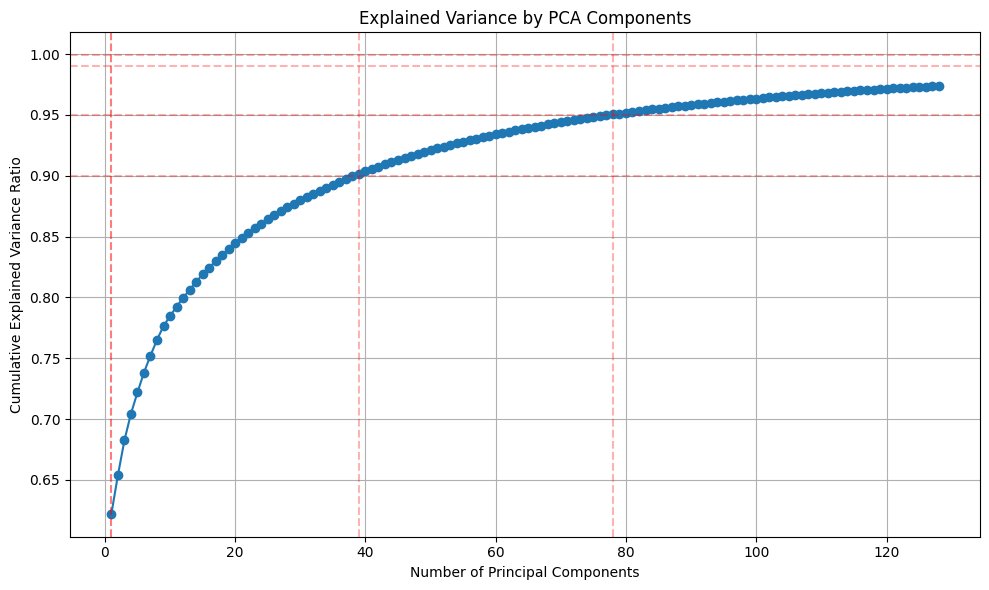

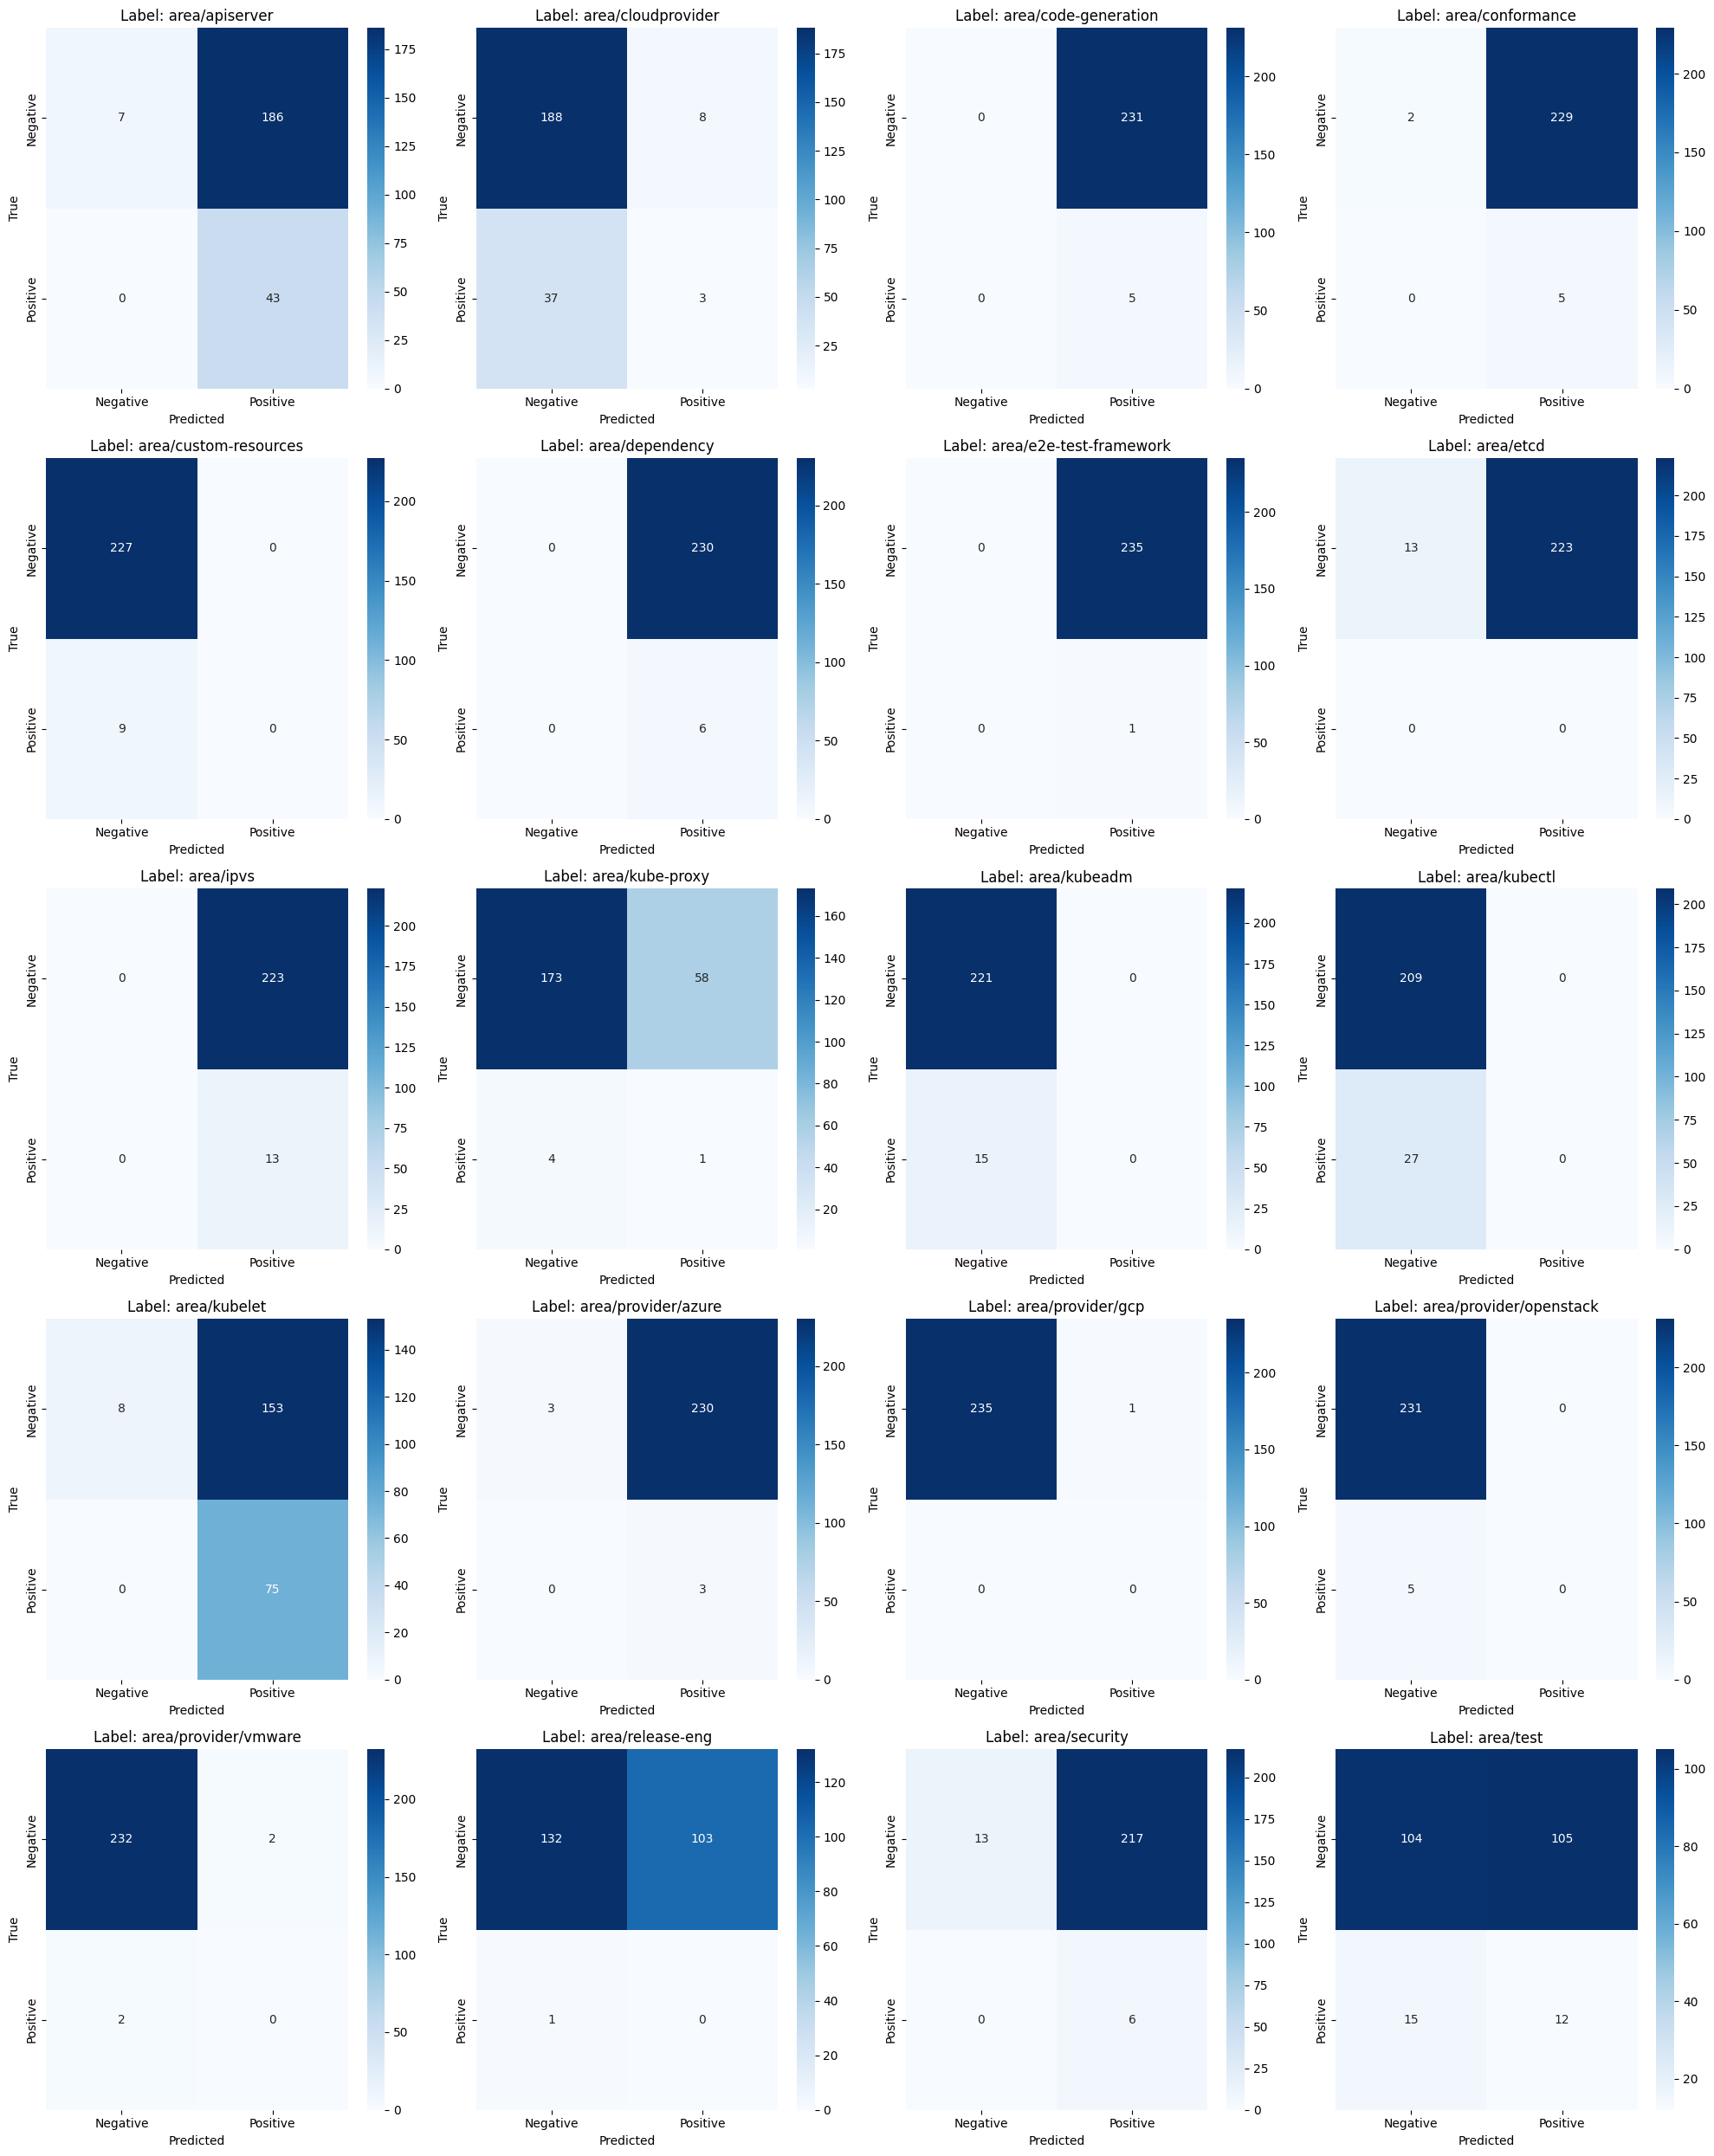

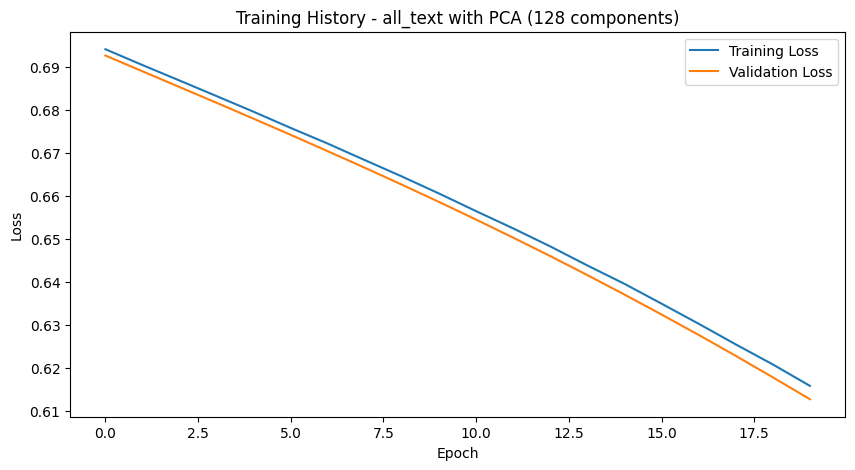

In [32]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train DeBERTa with PCA for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json",
                        help='Path to the JSON data file')
    parser.add_argument('--text_column', type=str, default='all_text',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=5,
                        help='Maximum number of labels per sample')
    parser.add_argument('--min_label_comb_freq', type=int, default=2,
                        help='Minimum frequency for a label combination')
    
    # PCA parameters
    parser.add_argument('--pca_components', type=int, default=128,
                        help='Number of PCA components to use')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=20, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=3, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', help='Use class weights for imbalanced data')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args) 

Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json...
Number of labels with at least 5 occurrences: 20
Removed 19 infrequent labels
Number of samples after filtering: 1258
Number of label combinations with at least 2 occurrences: 52
Removed 57 infrequent label combinations
Number of samples with frequent label combinations: 1201
Final number of samples after all filtering: 1177

 Label Distribution : 
0. area/kubelet: 358
1. area/test: 303
2. area/apiserver: 209
3. area/cloudprovider: 183
4. area/kubectl: 135
5. area/provider/azure: 66
6. area/dependency: 64
7. area/code-generation: 48
8. area/ipvs: 44
9. area/kubeadm: 39
10. area/kube-proxy: 27
11. area/provider/gcp: 22
12. area/e2e-test-framework: 17
13. area/conformance: 16
14. area/custom-resources: 15
15. area/release-eng: 14
16. area/security: 10
17. area/etcd: 5
18. area/provider/openstack: 5
19. area/provider/vmware: 2

 Label count pe

Extracting embeddings for PCA: 100%|██████████| 941/941 [01:11<00:00, 13.14it/s]


Components needed for 90.0% variance: 39
Components needed for 95.0% variance: 78
Components needed for 99.0% variance: 219
Components needed for 99.9% variance: 1
Creating PCA-reduced datasets...


Computing PCA embeddings: 100%|██████████| 236/236 [00:17<00:00, 13.66it/s]


Using larger batch size of 32 for 2 GPUs
Initializing PCA classifier model...
Starting training for 40 epochs...

Epoch 1/40


Training: 100%|██████████| 30/30 [00:00<00:00, 454.15it/s]


Train Loss: 0.6949, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6932
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.7754
Val Accuracy (Jaccard): 0.0809
Val Precision: 0.0818, Val Recall: 0.7754, Val F1: 0.1456
Saved new best model to ./results/run_20250325_174011_all_text_pca256/best_model_all_text_pca256.pt

Epoch 2/40


Training: 100%|██████████| 30/30 [00:00<00:00, 418.15it/s]


Train Loss: 0.6921, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6904
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.6694
Val Accuracy (Jaccard): 0.0849
Val Precision: 0.0862, Val Recall: 0.6694, Val F1: 0.1499
Saved new best model to ./results/run_20250325_174011_all_text_pca256/best_model_all_text_pca256.pt

Epoch 3/40


Training: 100%|██████████| 30/30 [00:00<00:00, 435.93it/s]


Train Loss: 0.6893, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6875
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.5110
Val Accuracy (Jaccard): 0.0857
Val Precision: 0.0884, Val Recall: 0.5110, Val F1: 0.1476

Epoch 4/40


Training: 100%|██████████| 30/30 [00:00<00:00, 464.56it/s]


Train Loss: 0.6865, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6847
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.3507
Val Accuracy (Jaccard): 0.0780
Val Precision: 0.0813, Val Recall: 0.3507, Val F1: 0.1290

Epoch 5/40


Training: 100%|██████████| 30/30 [00:00<00:00, 482.03it/s]


Train Loss: 0.6837, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6817
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.2773
Val Accuracy (Jaccard): 0.0776
Val Precision: 0.0821, Val Recall: 0.2773, Val F1: 0.1228

Epoch 6/40


Training: 100%|██████████| 30/30 [00:00<00:00, 481.85it/s]


Train Loss: 0.6807, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6787
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.1956
Val Accuracy (Jaccard): 0.0682
Val Precision: 0.0724, Val Recall: 0.1956, Val F1: 0.1023

Epoch 7/40


Training: 100%|██████████| 30/30 [00:00<00:00, 431.19it/s]


Train Loss: 0.6777, Train Accuracy (Exact Match): 0.0021
Val Loss: 0.6756
Val Accuracy (Exact Match): 0.0042
Val Accuracy (Partial Match): 0.0869
Val Accuracy (Jaccard): 0.0378
Val Precision: 0.0381, Val Recall: 0.0869, Val F1: 0.0518

Epoch 8/40


Training: 100%|██████████| 30/30 [00:00<00:00, 477.94it/s]


Train Loss: 0.6746, Train Accuracy (Exact Match): 0.0074
Val Loss: 0.6725
Val Accuracy (Exact Match): 0.0042
Val Accuracy (Partial Match): 0.0127
Val Accuracy (Jaccard): 0.0078
Val Precision: 0.0078, Val Recall: 0.0127, Val F1: 0.0092

Epoch 9/40


Training: 100%|██████████| 30/30 [00:00<00:00, 468.60it/s]


Train Loss: 0.6714, Train Accuracy (Exact Match): 0.0117
Val Loss: 0.6692
Val Accuracy (Exact Match): 0.0042
Val Accuracy (Partial Match): 0.0085
Val Accuracy (Jaccard): 0.0064
Val Precision: 0.0064, Val Recall: 0.0085, Val F1: 0.0071

Epoch 10/40


Training: 100%|██████████| 30/30 [00:00<00:00, 470.55it/s]


Train Loss: 0.6682, Train Accuracy (Exact Match): 0.0064
Val Loss: 0.6658
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 11/40


Training: 100%|██████████| 30/30 [00:00<00:00, 479.04it/s]


Train Loss: 0.6647, Train Accuracy (Exact Match): 0.0021
Val Loss: 0.6622
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 12/40


Training: 100%|██████████| 30/30 [00:00<00:00, 441.29it/s]


Train Loss: 0.6612, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6586
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 13/40


Training: 100%|██████████| 30/30 [00:00<00:00, 454.15it/s]


Train Loss: 0.6575, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6548
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 14/40


Training: 100%|██████████| 30/30 [00:00<00:00, 442.83it/s]


Train Loss: 0.6537, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6508
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 15/40


Training: 100%|██████████| 30/30 [00:00<00:00, 483.81it/s]


Train Loss: 0.6498, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6467
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 16/40


Training: 100%|██████████| 30/30 [00:00<00:00, 441.32it/s]


Train Loss: 0.6456, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6425
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 17/40


Training: 100%|██████████| 30/30 [00:00<00:00, 456.10it/s]


Train Loss: 0.6412, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6381
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 18/40


Training: 100%|██████████| 30/30 [00:00<00:00, 459.81it/s]


Train Loss: 0.6370, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6335
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 19/40


Training: 100%|██████████| 30/30 [00:00<00:00, 453.40it/s]


Train Loss: 0.6324, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6288
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 20/40


Training: 100%|██████████| 30/30 [00:00<00:00, 473.52it/s]


Train Loss: 0.6277, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6240
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 21/40


Training: 100%|██████████| 30/30 [00:00<00:00, 446.41it/s]


Train Loss: 0.6230, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6190
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 22/40


Training: 100%|██████████| 30/30 [00:00<00:00, 467.81it/s]


Train Loss: 0.6178, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6138
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 23/40


Training: 100%|██████████| 30/30 [00:00<00:00, 441.92it/s]


Train Loss: 0.6127, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6085
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 24/40


Training: 100%|██████████| 30/30 [00:00<00:00, 429.08it/s]


Train Loss: 0.6076, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6031
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 25/40


Training: 100%|██████████| 30/30 [00:00<00:00, 420.88it/s]


Train Loss: 0.6021, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.5976
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 26/40


Training: 100%|██████████| 30/30 [00:00<00:00, 402.07it/s]


Train Loss: 0.5966, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.5919
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 27/40


Training: 100%|██████████| 30/30 [00:00<00:00, 409.04it/s]


Train Loss: 0.5911, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.5861
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 28/40


Training: 100%|██████████| 30/30 [00:00<00:00, 420.57it/s]


Train Loss: 0.5852, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.5802
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 29/40


Training: 100%|██████████| 30/30 [00:00<00:00, 431.53it/s]


Train Loss: 0.5795, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.5742
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 30/40


Training: 100%|██████████| 30/30 [00:00<00:00, 455.53it/s]


Train Loss: 0.5734, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.5680
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 31/40


Training: 100%|██████████| 30/30 [00:00<00:00, 423.91it/s]


Train Loss: 0.5672, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.5618
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 32/40


Training: 100%|██████████| 30/30 [00:00<00:00, 404.92it/s]


Train Loss: 0.5613, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.5556
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 33/40


Training: 100%|██████████| 30/30 [00:00<00:00, 441.71it/s]


Train Loss: 0.5550, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.5492
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 34/40


Training: 100%|██████████| 30/30 [00:00<00:00, 408.25it/s]


Train Loss: 0.5487, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.5428
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 35/40


Training: 100%|██████████| 30/30 [00:00<00:00, 415.12it/s]


Train Loss: 0.5424, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.5363
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 36/40


Training: 100%|██████████| 30/30 [00:00<00:00, 428.62it/s]


Train Loss: 0.5360, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.5297
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 37/40


Training: 100%|██████████| 30/30 [00:00<00:00, 427.58it/s]


Train Loss: 0.5295, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.5231
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 38/40


Training: 100%|██████████| 30/30 [00:00<00:00, 423.82it/s]


Train Loss: 0.5231, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.5165
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 39/40


Training: 100%|██████████| 30/30 [00:00<00:00, 430.99it/s]


Train Loss: 0.5170, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.5099
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 40/40


Training: 100%|██████████| 30/30 [00:00<00:00, 449.05it/s]
<ipython-input-31-a85aa4ed9ccc>:221: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.loa

Train Loss: 0.5101, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.5032
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Loading best model for final evaluation...

Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.0000
Partial Match Accuracy: 0.6694
Jaccard Similarity: 0.0849
Precision: 0.0862
Recall: 0.6694
F1 Score: 0.1499

Training completed! Results saved to ./results/run_20250325_174011_all_text_pca256


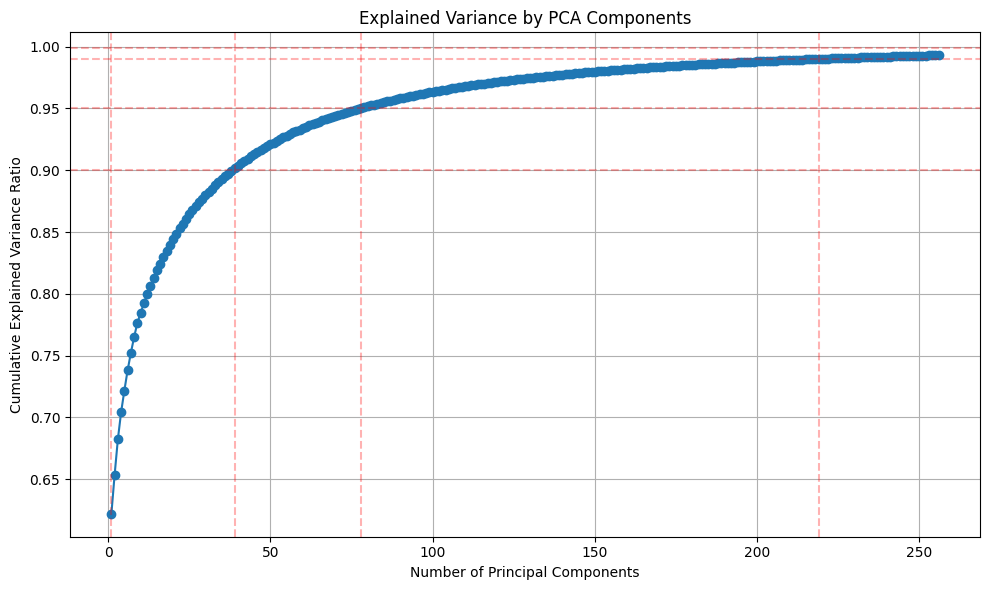

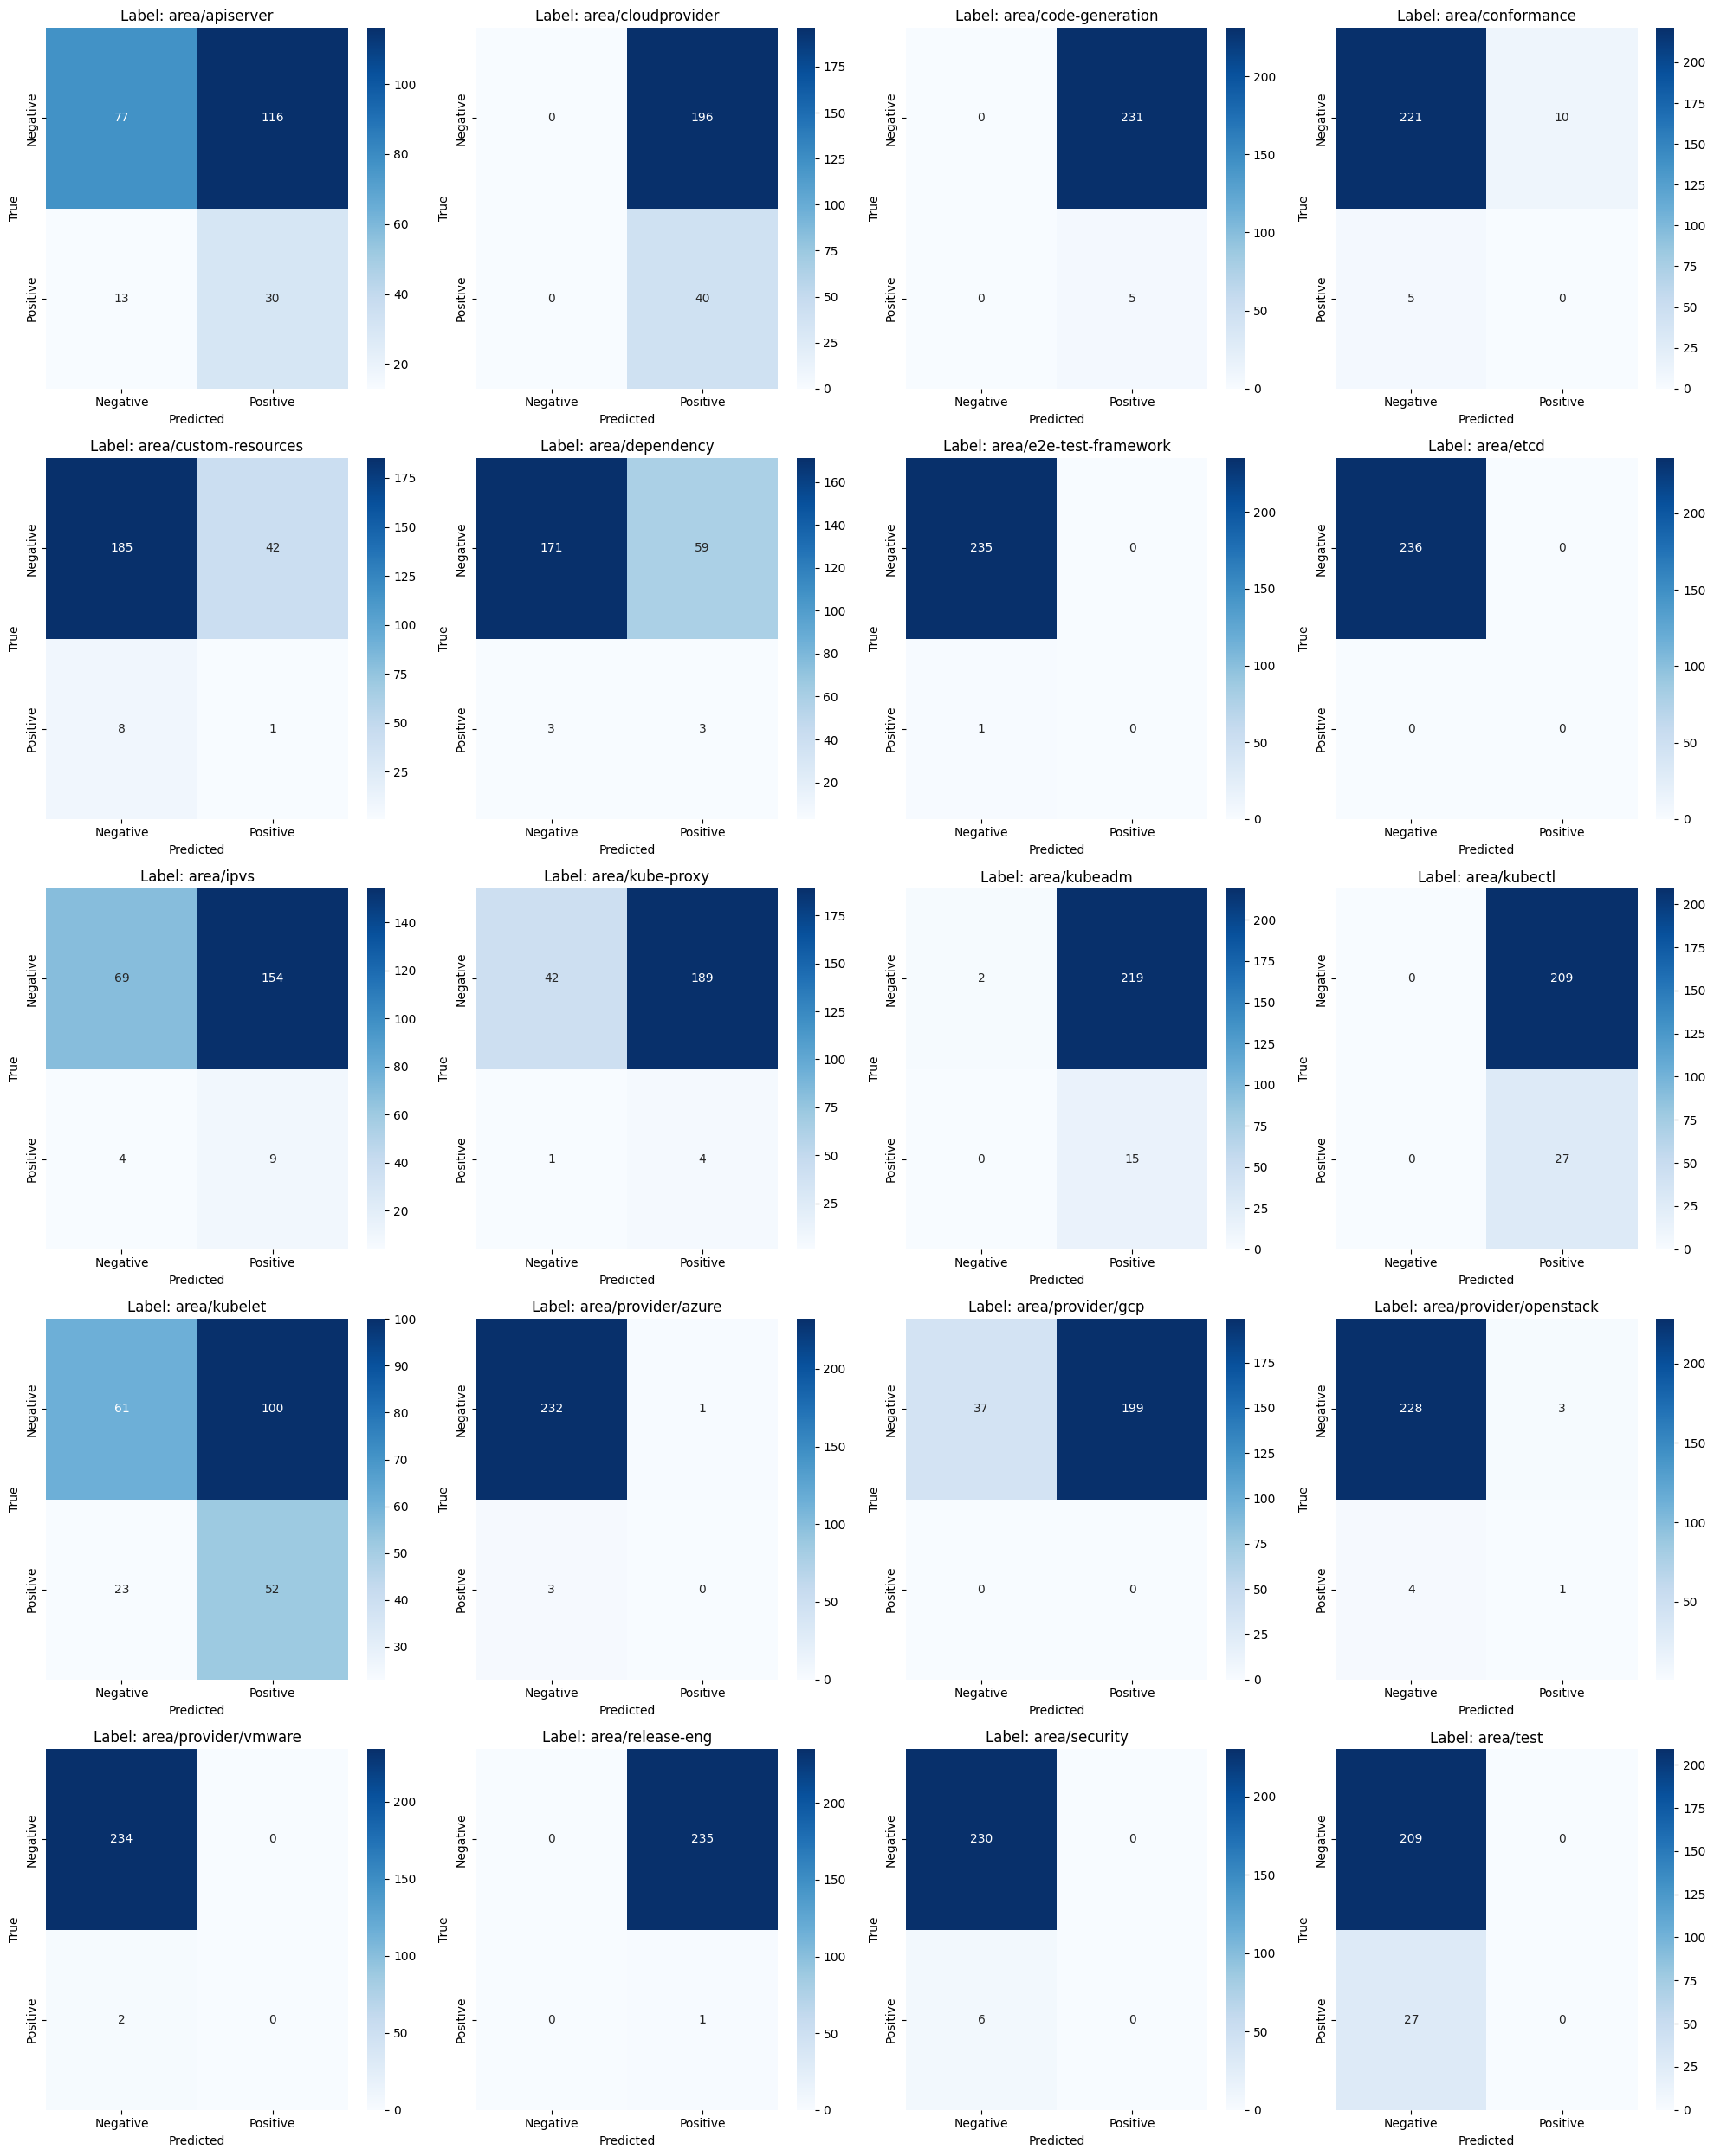

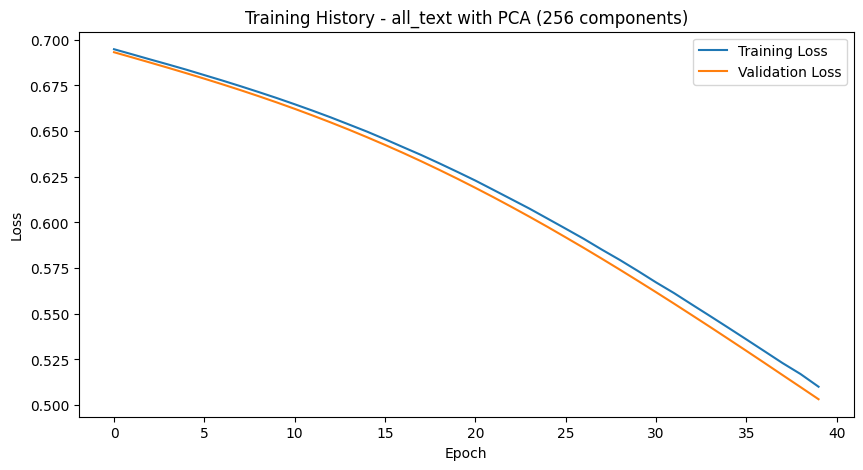

In [37]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train DeBERTa with PCA for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json",
                        help='Path to the JSON data file')
    parser.add_argument('--text_column', type=str, default='all_text',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=5,
                        help='Maximum number of labels per sample')
    parser.add_argument('--min_label_comb_freq', type=int, default=2,
                        help='Minimum frequency for a label combination')
    
    # PCA parameters
    parser.add_argument('--pca_components', type=int, default=256,
                        help='Number of PCA components to use')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=40, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=10, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', help='Use class weights for imbalanced data')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args) 

Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json...
Number of labels with at least 5 occurrences: 20
Removed 19 infrequent labels
Number of samples after filtering: 1258
Number of label combinations with at least 2 occurrences: 52
Removed 57 infrequent label combinations
Number of samples with frequent label combinations: 1201
Final number of samples after all filtering: 1177

 Label Distribution : 
0. area/kubelet: 358
1. area/test: 303
2. area/apiserver: 209
3. area/cloudprovider: 183
4. area/kubectl: 135
5. area/provider/azure: 66
6. area/dependency: 64
7. area/code-generation: 48
8. area/ipvs: 44
9. area/kubeadm: 39
10. area/kube-proxy: 27
11. area/provider/gcp: 22
12. area/e2e-test-framework: 17
13. area/conformance: 16
14. area/custom-resources: 15
15. area/release-eng: 14
16. area/security: 10
17. area/etcd: 5
18. area/provider/openstack: 5
19. area/provider/vmware: 2

 Label count pe

Extracting embeddings for PCA: 100%|██████████| 941/941 [01:11<00:00, 13.12it/s]


Components needed for 90.0% variance: 39
Components needed for 95.0% variance: 78
Components needed for 99.0% variance: 219
Components needed for 99.9% variance: 452
Creating PCA-reduced datasets...


Computing PCA embeddings: 100%|██████████| 236/236 [00:17<00:00, 13.72it/s]


Using larger batch size of 32 for 2 GPUs
Initializing PCA classifier model...
Starting training for 40 epochs...

Epoch 1/40


Training: 100%|██████████| 30/30 [00:00<00:00, 419.76it/s]


Train Loss: 0.6924, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6914
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.6648
Val Accuracy (Jaccard): 0.0868
Val Precision: 0.0884, Val Recall: 0.6648, Val F1: 0.1534
Saved new best model to ./results/run_20250325_173712_all_text_pca512/best_model_all_text_pca512.pt

Epoch 2/40


Training: 100%|██████████| 30/30 [00:00<00:00, 471.30it/s]


Train Loss: 0.6904, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6895
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.5949
Val Accuracy (Jaccard): 0.0921
Val Precision: 0.0942, Val Recall: 0.5949, Val F1: 0.1595
Saved new best model to ./results/run_20250325_173712_all_text_pca512/best_model_all_text_pca512.pt

Epoch 3/40


Training: 100%|██████████| 30/30 [00:00<00:00, 439.37it/s]


Train Loss: 0.6885, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6875
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.5441
Val Accuracy (Jaccard): 0.0949
Val Precision: 0.0973, Val Recall: 0.5441, Val F1: 0.1617
Saved new best model to ./results/run_20250325_173712_all_text_pca512/best_model_all_text_pca512.pt

Epoch 4/40


Training: 100%|██████████| 30/30 [00:00<00:00, 453.86it/s]


Train Loss: 0.6865, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6854
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.4975
Val Accuracy (Jaccard): 0.0982
Val Precision: 0.1018, Val Recall: 0.4975, Val F1: 0.1649
Saved new best model to ./results/run_20250325_173712_all_text_pca512/best_model_all_text_pca512.pt

Epoch 5/40


Training: 100%|██████████| 30/30 [00:00<00:00, 431.17it/s]


Train Loss: 0.6845, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6833
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.4424
Val Accuracy (Jaccard): 0.0922
Val Precision: 0.0960, Val Recall: 0.4424, Val F1: 0.1536

Epoch 6/40


Training: 100%|██████████| 30/30 [00:00<00:00, 450.76it/s]


Train Loss: 0.6824, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6812
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.2701
Val Accuracy (Jaccard): 0.0657
Val Precision: 0.0706, Val Recall: 0.2701, Val F1: 0.1079

Epoch 7/40


Training: 100%|██████████| 30/30 [00:00<00:00, 445.38it/s]


Train Loss: 0.6802, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6789
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.2054
Val Accuracy (Jaccard): 0.0594
Val Precision: 0.0666, Val Recall: 0.2054, Val F1: 0.0954

Epoch 8/40


Training: 100%|██████████| 30/30 [00:00<00:00, 447.20it/s]


Train Loss: 0.6779, Train Accuracy (Exact Match): 0.0011
Val Loss: 0.6766
Val Accuracy (Exact Match): 0.0042
Val Accuracy (Partial Match): 0.0792
Val Accuracy (Jaccard): 0.0383
Val Precision: 0.0487, Val Recall: 0.0792, Val F1: 0.0549

Epoch 9/40


Training: 100%|██████████| 30/30 [00:00<00:00, 440.97it/s]


Train Loss: 0.6754, Train Accuracy (Exact Match): 0.0106
Val Loss: 0.6741
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0078
Val Accuracy (Jaccard): 0.0056
Val Precision: 0.0106, Val Recall: 0.0078, Val F1: 0.0078

Epoch 10/40


Training: 100%|██████████| 30/30 [00:00<00:00, 425.30it/s]


Train Loss: 0.6730, Train Accuracy (Exact Match): 0.0106
Val Loss: 0.6715
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 11/40


Training: 100%|██████████| 30/30 [00:00<00:00, 426.53it/s]


Train Loss: 0.6703, Train Accuracy (Exact Match): 0.0021
Val Loss: 0.6687
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 12/40


Training: 100%|██████████| 30/30 [00:00<00:00, 478.60it/s]


Train Loss: 0.6675, Train Accuracy (Exact Match): 0.0011
Val Loss: 0.6658
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 13/40


Training: 100%|██████████| 30/30 [00:00<00:00, 469.51it/s]


Train Loss: 0.6645, Train Accuracy (Exact Match): 0.0011
Val Loss: 0.6627
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 14/40


Training: 100%|██████████| 30/30 [00:00<00:00, 429.43it/s]


Train Loss: 0.6614, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6595
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 15/40


Training: 100%|██████████| 30/30 [00:00<00:00, 473.60it/s]


Train Loss: 0.6581, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6560
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 16/40


Training: 100%|██████████| 30/30 [00:00<00:00, 436.02it/s]


Train Loss: 0.6546, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6524
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 17/40


Training: 100%|██████████| 30/30 [00:00<00:00, 433.21it/s]


Train Loss: 0.6509, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6486
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 18/40


Training: 100%|██████████| 30/30 [00:00<00:00, 485.94it/s]


Train Loss: 0.6470, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6445
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 19/40


Training: 100%|██████████| 30/30 [00:00<00:00, 475.88it/s]


Train Loss: 0.6429, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6403
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 20/40


Training: 100%|██████████| 30/30 [00:00<00:00, 473.42it/s]


Train Loss: 0.6386, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6358
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 21/40


Training: 100%|██████████| 30/30 [00:00<00:00, 461.48it/s]


Train Loss: 0.6342, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6312
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 22/40


Training: 100%|██████████| 30/30 [00:00<00:00, 417.35it/s]


Train Loss: 0.6294, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6263
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 23/40


Training: 100%|██████████| 30/30 [00:00<00:00, 427.08it/s]


Train Loss: 0.6246, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6213
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 24/40


Training: 100%|██████████| 30/30 [00:00<00:00, 425.85it/s]


Train Loss: 0.6196, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6161
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 25/40


Training: 100%|██████████| 30/30 [00:00<00:00, 434.21it/s]


Train Loss: 0.6143, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6106
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 26/40


Training: 100%|██████████| 30/30 [00:00<00:00, 406.51it/s]


Train Loss: 0.6089, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.6050
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 27/40


Training: 100%|██████████| 30/30 [00:00<00:00, 450.75it/s]


Train Loss: 0.6034, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.5993
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 28/40


Training: 100%|██████████| 30/30 [00:00<00:00, 415.94it/s]


Train Loss: 0.5977, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.5934
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 29/40


Training: 100%|██████████| 30/30 [00:00<00:00, 446.51it/s]


Train Loss: 0.5918, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.5873
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 30/40


Training: 100%|██████████| 30/30 [00:00<00:00, 416.09it/s]


Train Loss: 0.5858, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.5811
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 31/40


Training: 100%|██████████| 30/30 [00:00<00:00, 414.25it/s]


Train Loss: 0.5795, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.5748
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 32/40


Training: 100%|██████████| 30/30 [00:00<00:00, 434.45it/s]


Train Loss: 0.5733, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.5683
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 33/40


Training: 100%|██████████| 30/30 [00:00<00:00, 381.40it/s]


Train Loss: 0.5670, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.5617
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 34/40


Training: 100%|██████████| 30/30 [00:00<00:00, 407.92it/s]


Train Loss: 0.5605, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.5550
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 35/40


Training: 100%|██████████| 30/30 [00:00<00:00, 421.36it/s]


Train Loss: 0.5537, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.5482
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 36/40


Training: 100%|██████████| 30/30 [00:00<00:00, 405.13it/s]


Train Loss: 0.5473, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.5413
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 37/40


Training: 100%|██████████| 30/30 [00:00<00:00, 398.96it/s]


Train Loss: 0.5406, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.5343
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 38/40


Training: 100%|██████████| 30/30 [00:00<00:00, 406.69it/s]


Train Loss: 0.5335, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.5274
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 39/40


Training: 100%|██████████| 30/30 [00:00<00:00, 413.20it/s]


Train Loss: 0.5269, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.5203
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 40/40


Training: 100%|██████████| 30/30 [00:00<00:00, 461.32it/s]
<ipython-input-31-a85aa4ed9ccc>:221: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.loa

Train Loss: 0.5198, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.5132
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Loading best model for final evaluation...

Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.0000
Partial Match Accuracy: 0.4975
Jaccard Similarity: 0.0982
Precision: 0.1018
Recall: 0.4975
F1 Score: 0.1649

Training completed! Results saved to ./results/run_20250325_173712_all_text_pca512


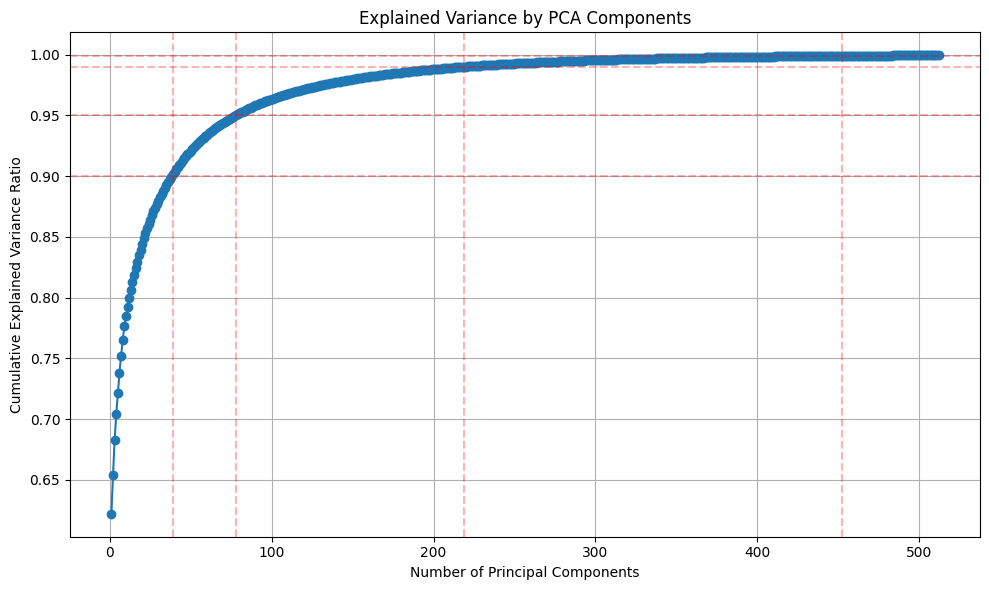

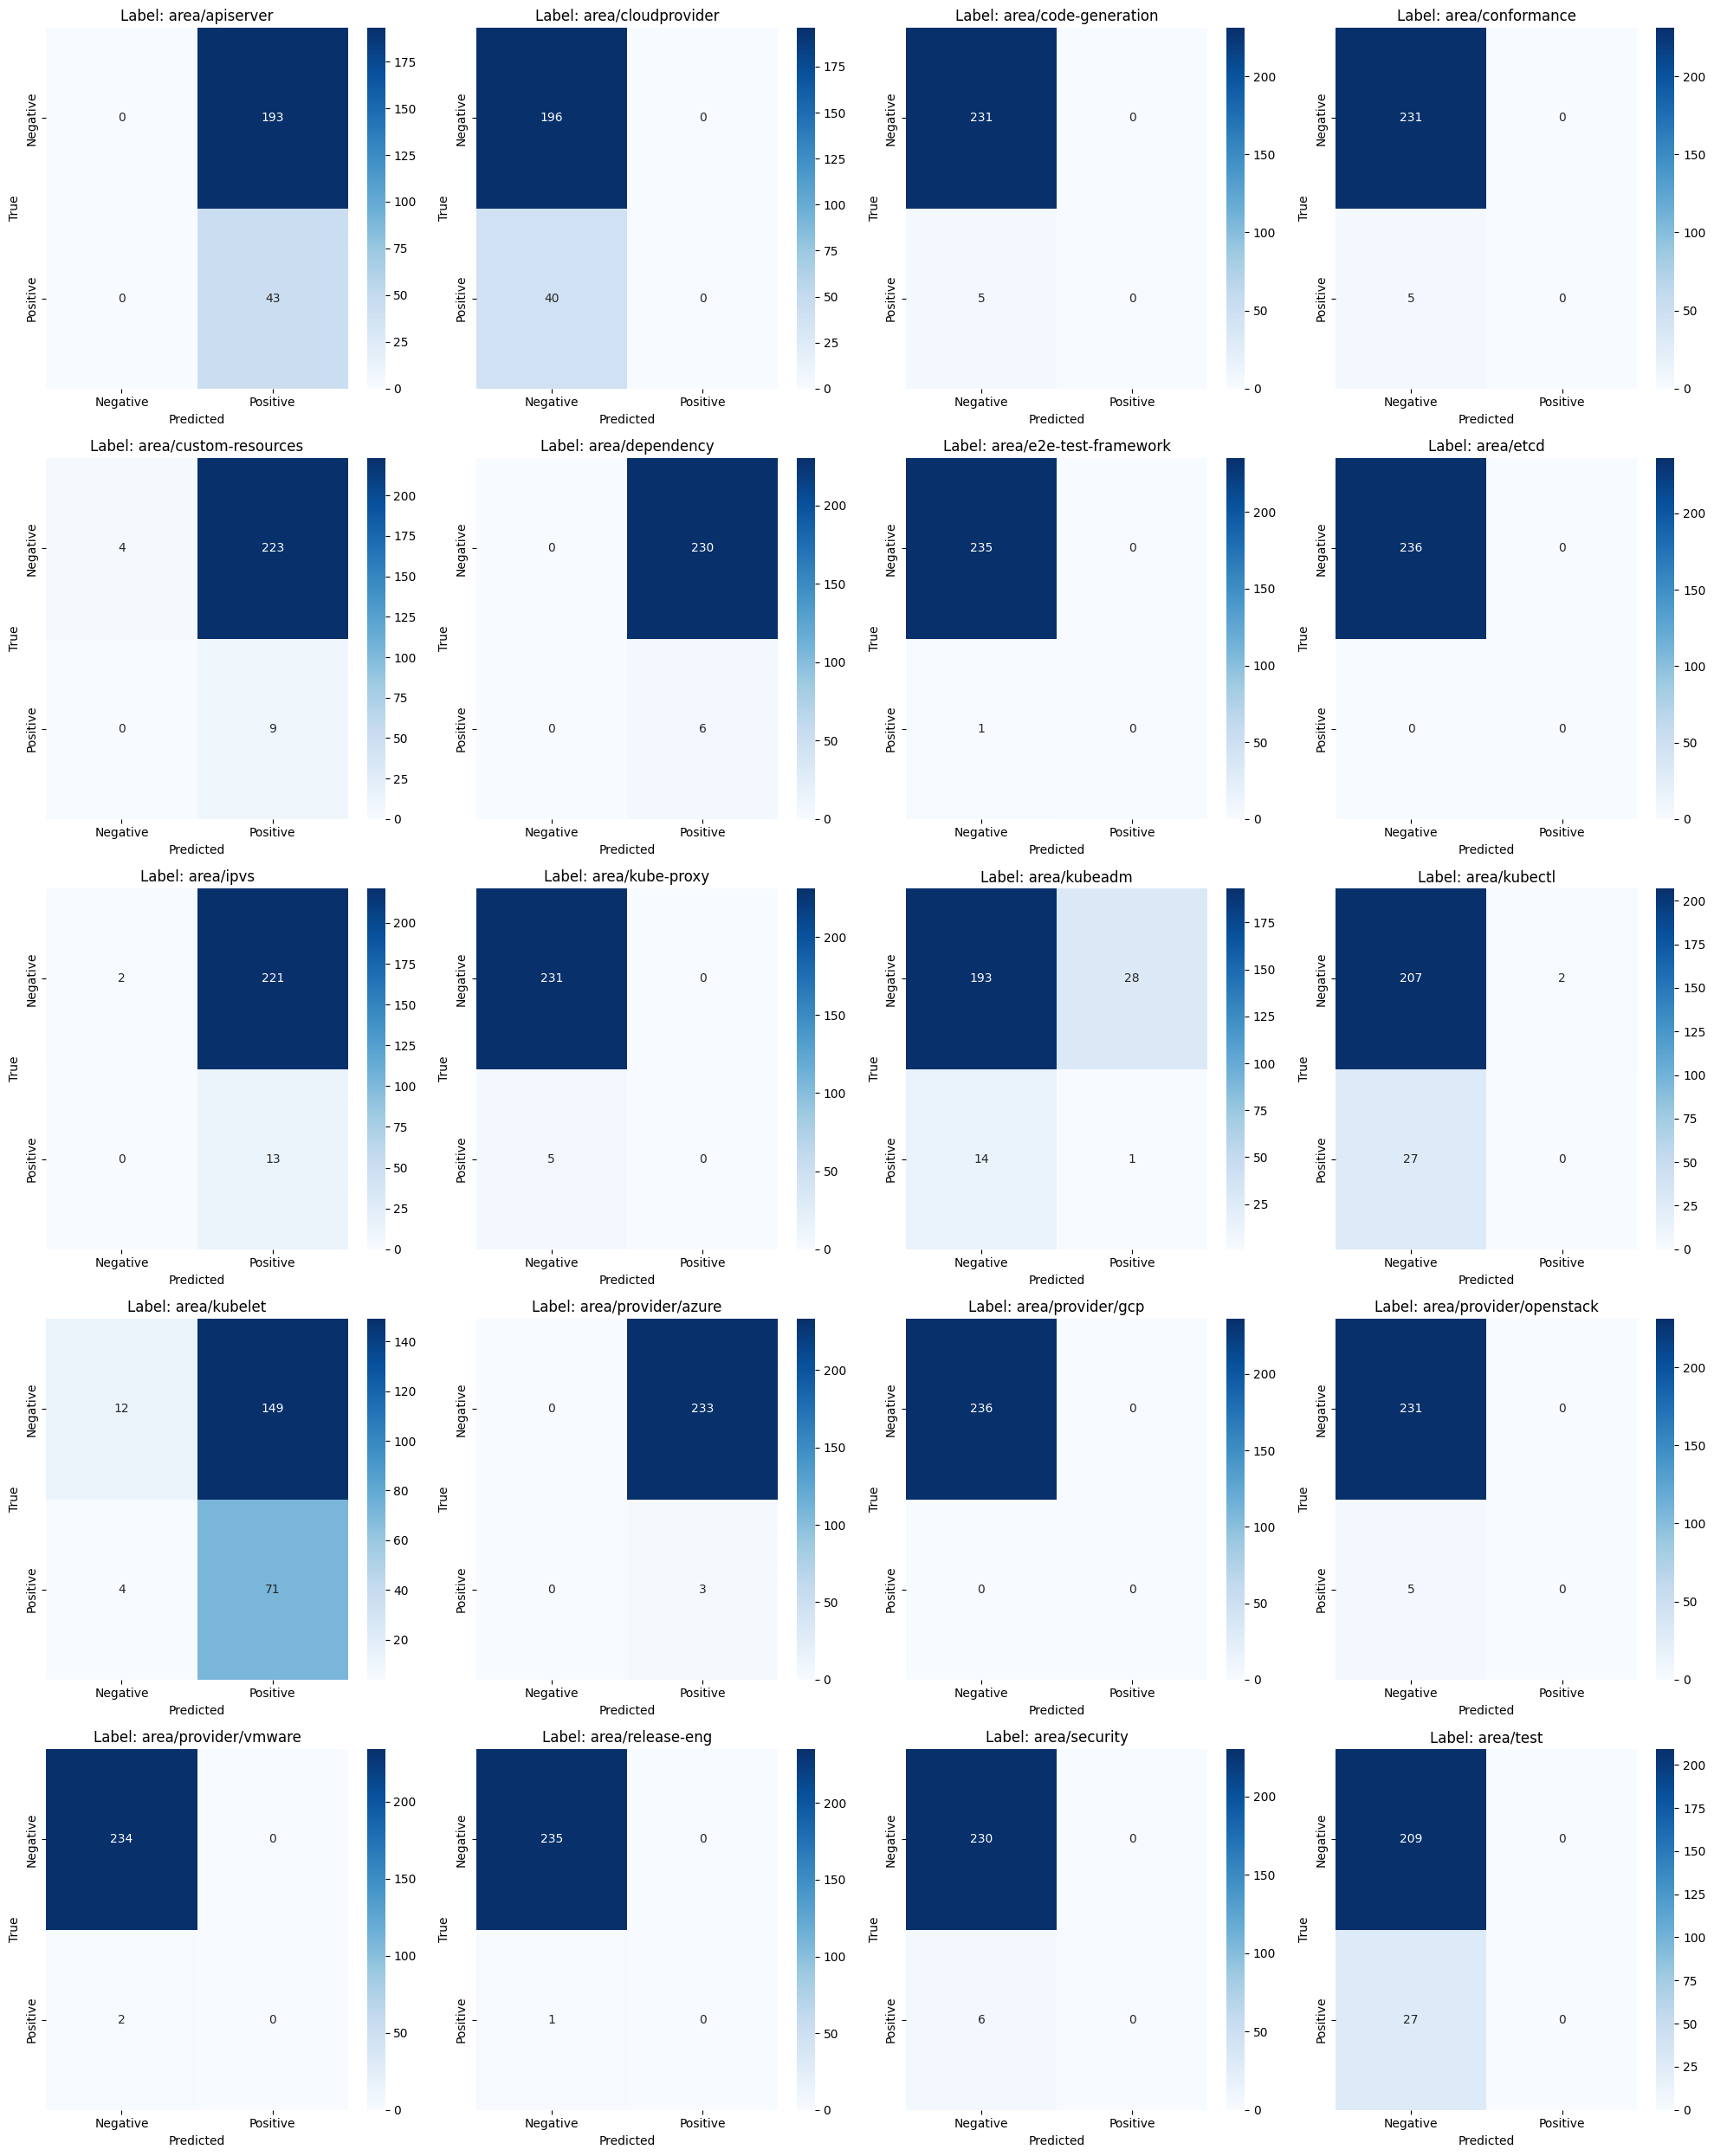

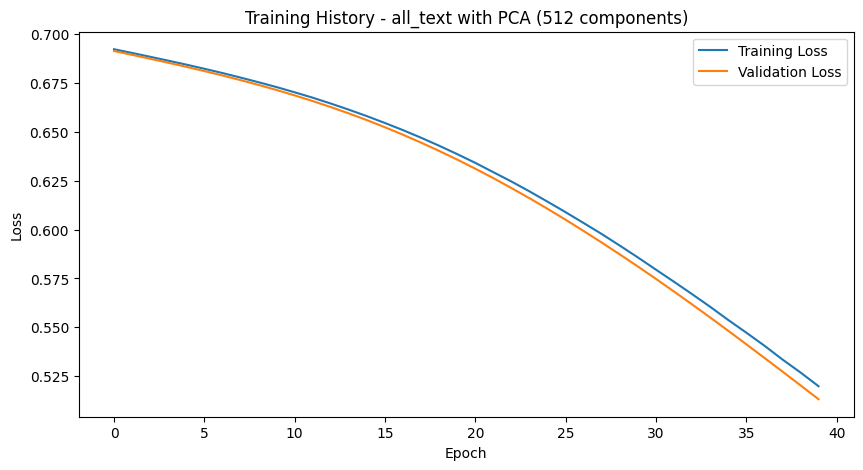

In [36]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train DeBERTa with PCA for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json",
                        help='Path to the JSON data file')
    parser.add_argument('--text_column', type=str, default='all_text',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=5,
                        help='Maximum number of labels per sample')
    parser.add_argument('--min_label_comb_freq', type=int, default=2,
                        help='Minimum frequency for a label combination')
    
    # PCA parameters
    parser.add_argument('--pca_components', type=int, default=512,
                        help='Number of PCA components to use')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=40, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=10, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', help='Use class weights for imbalanced data')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args) 